In [2]:
from monoscene.monoscene import MonoScene

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from helpers import *
from PIL import Image

In [4]:
model = MonoScene.load_from_checkpoint(
        "monoscene_kitti.ckpt",
        dataset="kitti",
        n_classes=20,
        feature = 64,
        project_scale = 4,
        full_scene_size = (256, 256, 32),
    )

c:\Users\user\anaconda3\envs\knk-autonomous\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.4.9 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\knk-autonomous\knk_vision\occupancy\monoscene_kitti.ckpt`


Loading base model ()...

Using cache found in C:\Users\user/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


In [5]:
img_W, img_H = 1220, 370

In [6]:
def predict(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = np.array(img, dtype=np.float32, copy=False) / 255.0

    normalize_rgb = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    img = normalize_rgb(img).to(device)
   
    batch = get_projections(img_W, img_H)
    batch["img"] = img
    for k in batch:
        batch[k] = batch[k].unsqueeze(0).to(device)
    model.to(device)
    with torch.no_grad():
        pred = model(batch).squeeze()
    fig = draw(pred, batch['fov_mask_2'].cpu().detach().numpy())

    return pred,fig

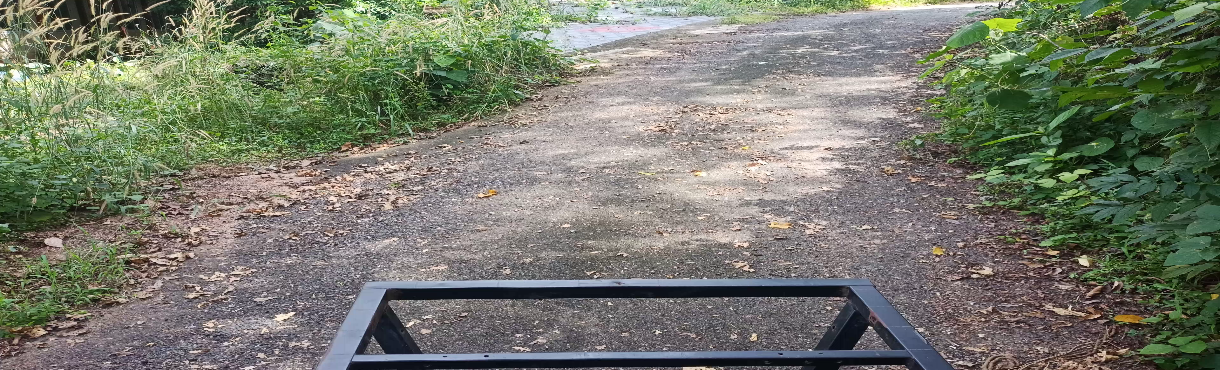

In [7]:

cap = cv2.VideoCapture("test_vid/test_cam1.mp4")
# while True:
ret, frame = cap.read()
# if not ret:
#     break
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized_frame = cv2.resize(frame, (img_W, img_H))
frame = Image.fromarray(resized_frame)
pred, fig = predict(frame)
frame

In [8]:
fig